In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint

# Data wrangling

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.columns

Index(['fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude',
       'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [5]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

df.head()

,fire_size,fire_size_class,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Cause,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16,Cause_Campfire,Cause_Children,Cause_Debris Burning,Cause_Equipment Use,Cause_Fireworks,Cause_Lightning,Cause_Miscellaneous,Cause_Missing/Undefined,Cause_Powerline,Cause_Railroad,Cause_Smoking,Cause_Structure
0,10.0,C,18.105072,-66.753044,PR,2007-02-11,Feb,1/12/2007,2007,Jan,785140,58917.69716,11603,1945,2018,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923,Missing/Undefined,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.0,B,35.038330,-87.610000,TN,2006-12-11,Dec,11/11/2006,2006,Nov,723235,32665.34327,13896,1978,2020,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355,Arson,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60.0,C,34.947800,-88.722500,MS,2004-02-29,Feb,1/30/2004,2004,Jan,723235,105122.14950,13896,1978,2020,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544,Arson,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,B,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447,Debris Burning,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2.0,B,30.700600,-90.591400,LA,1999-09-22,Sep,8/23/1999,1999,Aug,722312,25940.57409,3908,1987,2016,0.1,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633,Miscellaneous,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


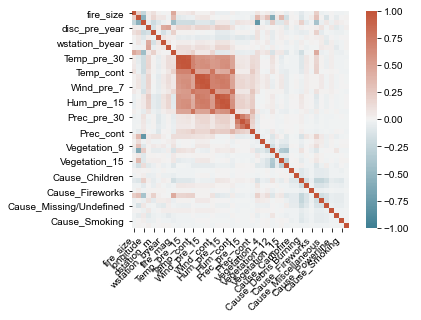

In [6]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,16)})

In [7]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

# Weather data has a lot of 0 values some of which may be missing values
# So here we mark '0' values in weather columns as Na (to see how many there are)
subset = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset] = df[subset].replace({0:np.nan, '0':np.nan})

# Mark -1 as missing
subset_neg1 = ['Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont'])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill current NAs based on mean values from previous days
df['Temp_cont'] = df.apply(
    lambda row: (row['Temp_pre_7']+row['Temp_pre_15']+row['Temp_pre_30'])/3 if np.isnan(row['Temp_cont']) else row['Temp_cont'],
    axis=1)

df['Wind_cont'] = df.apply(
    lambda row: (row['Wind_pre_7']+row['Wind_pre_15']+row['Wind_pre_30'])/3 if np.isnan(row['Wind_cont']) else row['Wind_cont'],
    axis=1)

df['Hum_cont'] = df.apply(
    lambda row: (row['Hum_pre_7']+row['Hum_pre_15']+row['Hum_pre_30'])/3 if np.isnan(row['Hum_cont']) else row['Hum_cont'],
    axis=1)

55367
41132
38689


In [8]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size'] + df['fire_mag']

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelling
### Decision trees

In [35]:
# Deccision trees
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [36]:
predictions = dectr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3412.9348744055314
R Squared: -0.5227685592697597


### Gradient Boosting

In [ ]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(X_train, y_train)

In [ ]:
predictions = gr_boost.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

### XGBoost

In [37]:
XGBModel = XGBRegressor(n_estimators=10)
XGBModel.fit(X_train, y_train, verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = metrics.mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
print('R Squared:', metrics.r2_score(y_test, XGBpredictions))

XGBoost validation MAE =  2946.564253518771
R Squared: 0.1047734092282111


### Random Forest

In [9]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 250, max_depth=8)

# fit the regressor with x and y data
rf_reg.fit(X_train, y_train)  

RandomForestRegressor(max_depth=8, n_estimators=250)

In [10]:
predictions = rf_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 2930.2376366066646
R Squared: 0.12106882353279536


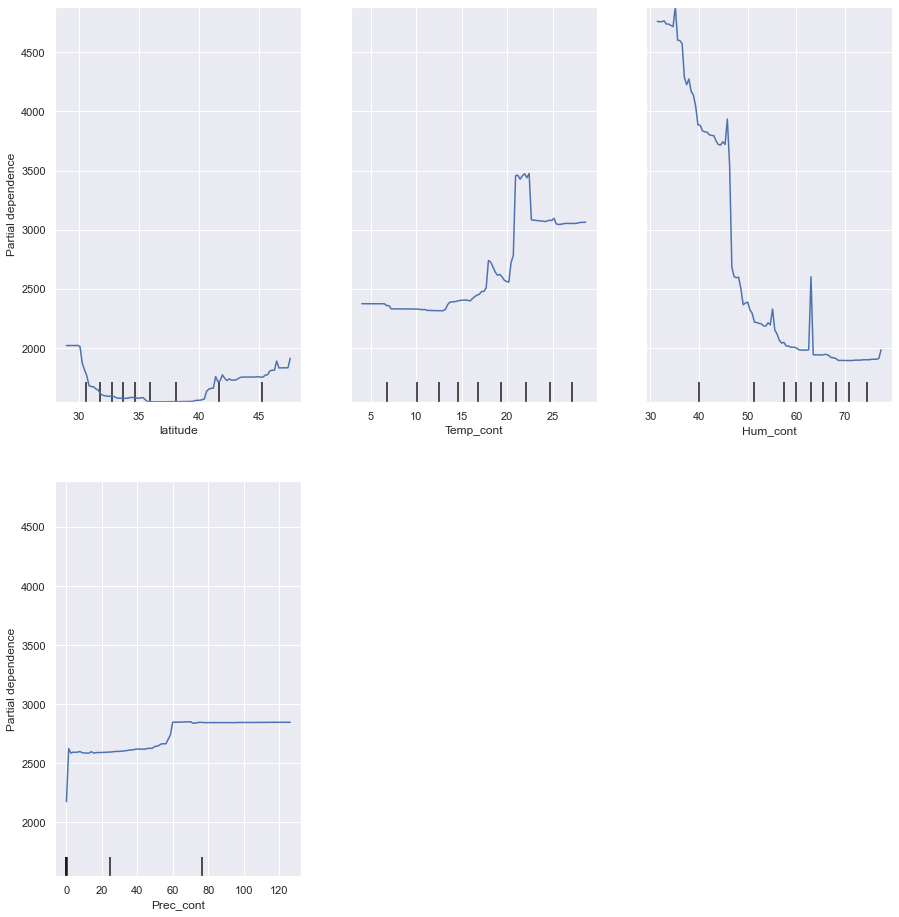

In [11]:
features = [6, 10, 18, 22]
plot_partial_dependence(rf_reg, X, features)

### Hyper-parameter tuning
Performing Grid Search
Testing the model with different values for parameters like the number of estimators and maximum depth, and then selects the parametres that produce the best results.

The basemodel of Random Forest Regressor produced the best results, so that is the algorithm we will tune.

In [34]:
# Shwo which parameters can be tuned
rf_reg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [43]:
#XGBModel.get_params().keys()

In [124]:
search_grid={'n_estimators':[10,50,100,250],'max_depth':[2,4,5,6,7,8]}
rfreg = RandomForestRegressor()
search=GridSearchCV(estimator=gbr,param_grid=search_grid,scoring='r2',n_jobs=1,cv=5)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

0.15844188723246325
{'max_depth': 8, 'n_estimators': 250}


In [12]:
#search_grid={'n_estimators':[10,50,100,250]}
#searchxgb=GridSearchCV(estimator=XGBModel,param_grid=search_grid,scoring='r2',n_jobs=1,cv=3)
#searchxgb.fit(X_train, y_train)
print(searchxgb.best_score_)
print(searchxgb.best_params_)

NameError: name 'searchxgb' is not defined

### Fetaure Importance
What features are the most influential in the model?

In [20]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
    index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
latitude,0.202438
longitude,0.111065
Hum_cont,0.097083
Temp_cont,0.067860
Wind_pre_7,0.065260
Hum_pre_30,0.055445
Wind_pre_30,0.052766
Temp_pre_30,0.047980
Temp_pre_15,0.044049
Hum_pre_7,0.042197


Reevaluate model after deleting least important features

In [23]:
# selecting features and target variables
X2 = df[['Vegetation_9','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning', 'longitude']]
y2 = df['fire_size'] + df['fire_mag']

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [24]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 250, max_depth=8)

# fit the regressor with x and y data
rf_reg.fit(X_train, y_train)

predictions = rf_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 2943.495886495163
R Squared: 0.12624457288822366


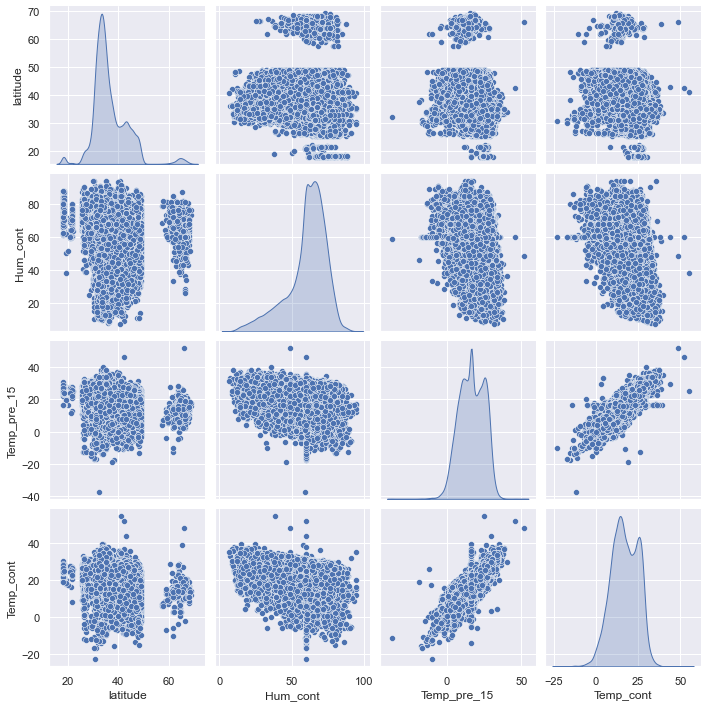

In [13]:
sns.pairplot(X_train[['latitude', 'Hum_cont', 'Temp_pre_15', 'Temp_cont']], diag_kind='kde')

In [77]:
#PCA Analysis
X_scaled = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

X_pcca = principalDf[['pc1','pc2','pc3','pc4','pc5']]

Neural network model

In [91]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [92]:
model = Sequential([
    normalizer,
    Dense(33, activation="relu", kernel_initializer='normal',input_dim = X_train.shape[1]),
    Dense(64, activation="relu"),
#    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['accuracy']
)

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

In [93]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.15, callbacks=[checkpoint])

Epoch 1/20
823/823 [==============================] - 2s 1ms/step - loss: 2234.5852 - accuracy: 0.0026 - val_loss: 2391.0027 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 2391.00269, saving model to Weights-001--2391.00269.hdf5
Epoch 2/20
823/823 [==============================] - 1s 1ms/step - loss: 2149.0852 - accuracy: 0.0027 - val_loss: 2350.9507 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 2391.00269 to 2350.95068, saving model to Weights-002--2350.95068.hdf5
Epoch 3/20
823/823 [==============================] - 1s 1ms/step - loss: 2137.2061 - accuracy: 0.0027 - val_loss: 2344.9312 - val_accuracy: 0.0017

Epoch 00003: val_loss improved from 2350.95068 to 2344.93115, saving model to Weights-003--2344.93115.hdf5
Epoch 4/20
823/823 [==============================] - 1s 1ms/step - loss: 2132.0042 - accuracy: 0.0027 - val_loss: 2342.4255 - val_accuracy: 0.0017

Epoch 00004: val_loss improved from 2344.93115 to 2342.42554, saving model to Weights-004-

In [94]:
model.evaluate(X_test, y_test)

242/242 [==============================] - 0s 789us/step - loss: 2172.1113 - accuracy: 0.0022


[2172.111328125, 0.002196950139477849]

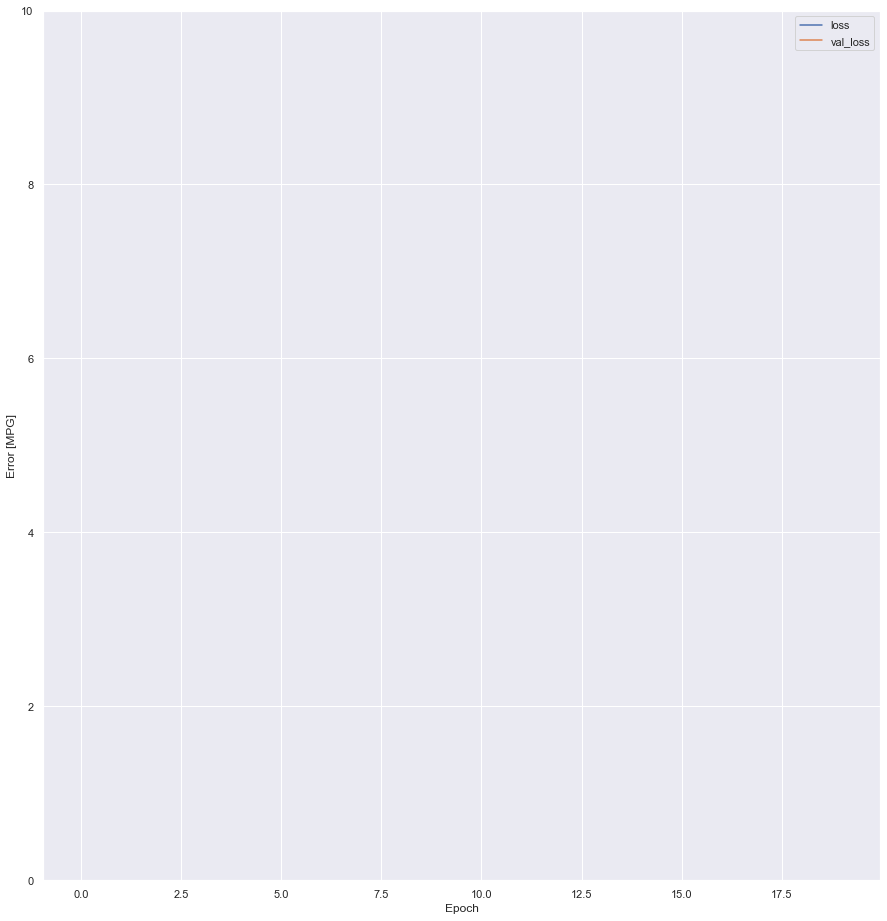

In [95]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

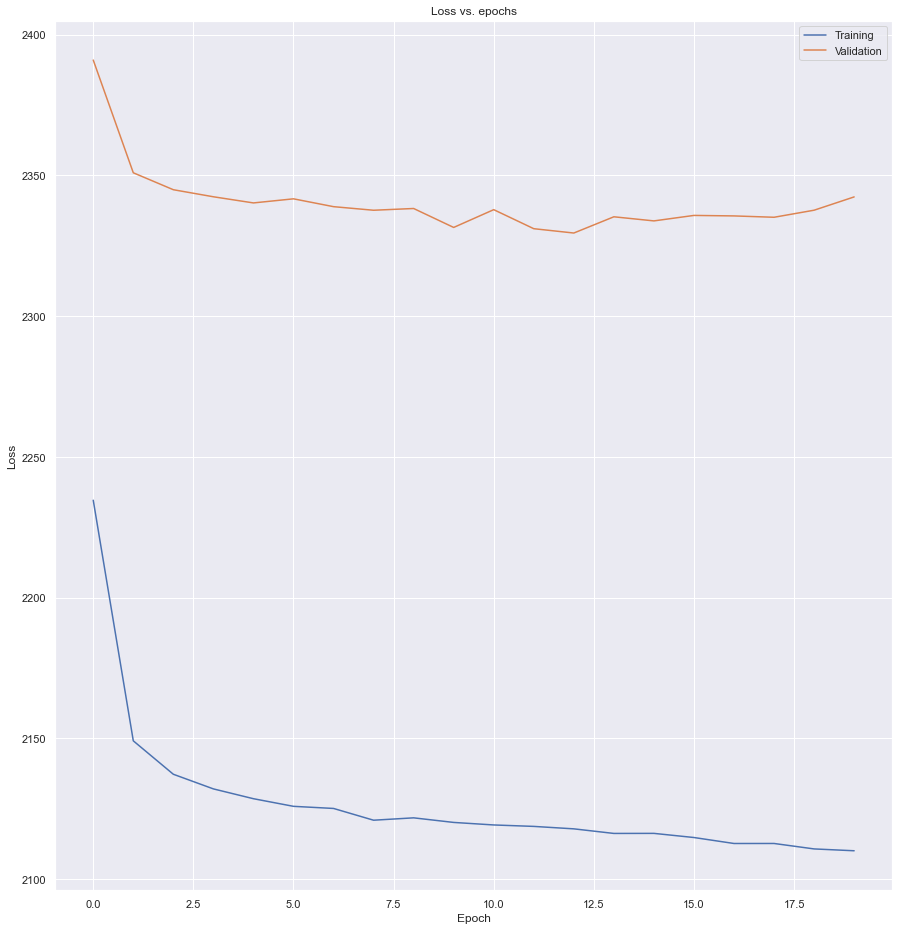

In [96]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Other

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])